In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e

dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed'
    }

# TSS_HK1 = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] == '1':
#             TSS_HK1.append(TSS(ll[0], int(ll[1])+int(1000)))

TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(ll[1])+int(1000)))


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))

# TSS_NonGene1 = TSS_NonGene[:len(TSS_HK1)]
# TSS_NonGene2 = TSS_NonGene[len(TSS_HK1):len(TSS_HK1)+len(TSS_HK2)]

In [2]:
bamfile = ps.AlignmentFile(dic['bam123'],'rb')
up = 1000
down = 1000

In [8]:
feature_matrix_1 = []
for j, tss in enumerate(TSS_HK):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch(chrom, start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            # ss = max(0, r.reference_start - start)
            # ee = min(r.reference_start - start + abs(r.isize), end - start)
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 50
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win

        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        # ff.append(round(np.sum(down_end[ss:ee])))
        wps = 0
        for r in bamfile.fetch(chrom, ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        # for r in bamfile.fetch(chrom, ss+start, ss+win/2+start):
        #     if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
        #         if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ss+win/2+start:
        #             wps += 1
        #         elif ss + start < r.reference_start < ss+win/2+start:
        #             wps -= 1
        #         elif ss+start < r.reference_start + abs(r.isize) < ss+win/2+start:
        #             wps -= 1
        # for r in bamfile.fetch(chrom, ss+win/2+start, ee+start):
        #     if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
        #         if r.reference_start <= ss+win/2+start and r.reference_start+abs(r.isize) >= ee+start:
        #             wps += 1
        #         elif ss+win/2+start < r.reference_start < ee+start:
        #             wps -= 1
        #         elif ss+win/2+start < r.reference_start + abs(r.isize) < ee+start:
        #             wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix_1.append(feature_win)
feature_matrix_1 = np.array(feature_matrix_1)

In [9]:
feature_matrix_0 = []
for j, tss in enumerate(TSS_NonGene[:len(TSS_HK)]):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            # ss = max(0, r.reference_start - start)
            # ee = min(r.reference_start - start + abs(r.isize), end - start)
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 50
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win

        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        # ff.append(round(np.sum(down_end[ss:ee])))
        wps = 0
        for r in bamfile.fetch('1', ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        # for r in bamfile.fetch('1', ss+start, ss+win/2+start):
        #     if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
        #         if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ss+win/2+start:
        #             wps += 1
        #         elif ss + start < r.reference_start < ss+win/2+start:
        #             wps -= 1
        #         elif ss+start < r.reference_start + abs(r.isize) < ss+win/2+start:
        #             wps -= 1
        # for r in bamfile.fetch('1', ss+win/2+start, ee+start):
        #     if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
        #         if r.reference_start <= ss+win/2+start and r.reference_start+abs(r.isize) >= ee+start:
        #             wps += 1
        #         elif ss+win/2+start < r.reference_start < ee+start:
        #             wps -= 1
        #         elif ss+win/2+start < r.reference_start + abs(r.isize) < ee+start:
        #             wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix_0.append(feature_win)
feature_matrix_0 = np.array(feature_matrix_0)

In [10]:
import random
data_x = []
data_y = []
for mat in feature_matrix_1:
    data_x.append(mat)
    data_y.append(1)
for mat in feature_matrix_0:
    data_x.append(mat)
    data_y.append(0)
perm = random.sample(range(len(data_x)),len(data_x))
data_x = np.array(data_x)
data_y = np.array(data_y)
train_x = data_x[perm[:int(len(perm)*0.6)]]
train_y = data_y[perm[:int(len(perm)*0.6)]]
test_x = data_x[perm[int(len(perm)*0.6):]]
test_y = data_y[perm[int(len(perm)*0.6):]]

In [11]:
print(test_x.shape)

(656, 40, 4)


In [126]:
# import tensorflow as tf
# from tensorflow import keras
# # y_train = keras.utils.to_categorical(train_y,num_classes=2)
# # print(y_train.shape)
# # x_train = np.reshape(train_x,(len(train_x),40,4))
# # print(x_train.shape,train_x.shape)
# y_train = keras.utils.to_categorical(train_y)
# print(y_train.shape)

(590, 2)


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# y_train = keras.utils.to_categorical(train_y,num_classes=2)
# y_test = keras.utils.to_categorical(train_y,num_classes=2)
input_size = 4
time_steps = 40
cell_size = 20

model = keras.Sequential()
# model.add(keras.layers.Convolution1D(filters=100,kernel_size=10,input_shape=(time_steps,input_size),activation='relu',strides=1,padding='same'))
# model.add(keras.layers.MaxPooling1D(pool_size=2,strides=2))
# model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(40, return_sequences=True),input_shape=(time_steps, input_size)))
# model.add(keras.layers.LSTM(40,return_sequences=True,input_shape=(time_steps, input_size)))
model.add(keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(750, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None))

# print(model.summary())

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.1,
                        callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./' + 'weight.h5', save_best_only=True)],
                        shuffle=True, verbose=2)
loss, accuracy = model.evaluate(test_x, test_y)
model.save('./lstm.h5')
print(loss, accuracy)

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
7/7 - 3s - loss: 0.6542 - accuracy: 0.6195 - val_loss: 0.5316 - val_accuracy: 0.8586
Epoch 2/20
7/7 - 0s - loss: 0.5174 - accuracy: 0.7769 - val_loss: 0.3940 - val_accuracy: 0.8990
Epoch 3/20
7/7 - 0s - loss: 0.3963 - accuracy: 0.8641 - val_loss: 0.3183 - val_accuracy: 0.8990
Epoch 4/20
7/7 - 0s - loss: 0.3262 - accuracy: 0.8709 - val_loss: 0.3001 - val_accuracy: 0.9091
Epoch 5/20
7/7 - 0s - loss: 0.2804 - accuracy: 0.9060 - val_loss: 0.2724 - val_accuracy: 0.9091
Epoch 6/20
7/7 - 0s - loss: 0.2642 - accuracy: 0.9094 - val_loss: 0.2879 - val_accuracy: 0.9091
Epoch 7/20
7/7 - 0s - loss: 0.2446 - accuracy: 0.9173 - val_loss: 0.2686 - val_accuracy: 0.9192
Epoch 8/20
7/7 - 0s - loss: 0.2463 - accuracy: 0.9139 - val_loss: 0.2956 - val_accuracy: 0.9192
Epoch 9/20
7/7 - 0s - loss: 0.2385 - accuracy: 0.9185 - val_loss: 0.2661 - val_accuracy: 0.9192
Epoch 10/20
7/7 - 0s - loss: 0.2305 - accuracy: 0.9241 - val_loss: 0.2688 - val_accuracy: 0.9192
Epoch 11/20
7/7 - 0s - loss: 0.2268 - a

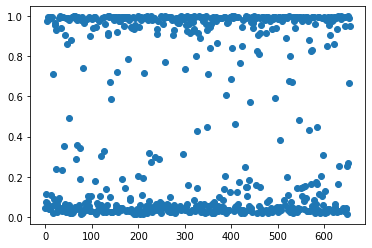

In [15]:
pre = model.predict(test_x,0)
plt.scatter([x for x in range(len(pre))], pre)
plt.show()

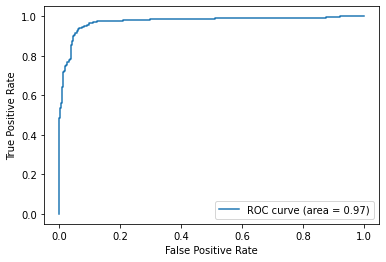

[1.9992477  0.99924767 0.99822605 0.9981861  0.99075127 0.99074364
 0.9886214  0.98860914 0.9878094  0.9877144  0.9795681  0.9789803
 0.9657432  0.9653727  0.9604472  0.9594888  0.95478475 0.95360684
 0.9518844  0.9510486  0.9485818  0.9480413  0.9456896  0.9425627
 0.939102   0.9370222  0.93438923 0.93412983 0.8833046  0.88090044
 0.84146965 0.8306427  0.7641925  0.74325806 0.7223168  0.7186103
 0.7127091  0.6790441  0.6049473  0.59461755 0.493321   0.48401853
 0.46340728 0.44579333 0.43182552 0.38425308 0.35720092 0.34150317
 0.32631925 0.32071042 0.31470942 0.30229646 0.2983999  0.2880762
 0.26628432 0.2546852  0.2524221  0.24910206 0.23994154 0.20502418
 0.20245183 0.18761799 0.1848436  0.15404603 0.15089113 0.10277602
 0.10242426 0.06471547 0.06452966 0.05418238 0.05367926 0.04218516
 0.04205906 0.04082483 0.04049462 0.02513915 0.02495769 0.02223653
 0.02216446 0.01524234]


In [16]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_y, pre, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print(thresholds)

In [233]:
'''
test on other genes
'''
dic_ = {    
    'Lung':'./excel/Lung.bed',
    'Tcell':'./excel/Tcell.bed',
    'Liver':'./excel/Liver.bed'
}
TSS_Liver = []
f = open(dic_['Liver'],'r')
for line in f:
    ll = line.strip().split('\t')
    if ll[0] in ['1']:
        TSS_Liver.append(TSS(ll[0],int(ll[1])))
f.close()
feature_matrix_Liver = []
for j, tss in enumerate(TSS_Liver):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            # ss = max(0, r.reference_start - start)
            # ee = min(r.reference_start - start + abs(r.isize), end - start)
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 50
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win

        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        # ff.append(round(np.sum(down_end[ss:ee])))
        wps = 0
        for r in bamfile.fetch('1', ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix_Liver.append(feature_win)
feature_matrix_Liver = np.array(feature_matrix_Liver)
test_Liver = []
for mat in feature_matrix_Liver:
    test_Liver.append(mat)

In [ ]:
test_Liver =np.array(test_Liver)
print(test_Liver.shape)
pre_Liver = model.predict(test_Liver,0)
plt.scatter([x for x in range(len(pre_Liver))],pre_Liver)
plt.show()

In [236]:
TSS_Tcell = []
f = open(dic_['Tcell'],'r')
for line in f:
    ll = line.strip().split('\t')
    if ll[0] in ['1']:
        TSS_Tcell.append(TSS(ll[0],int(ll[1])))
        if len(TSS_Tcell) > 800:
            break
f.close()
feature_matrix_Tcell = []
for j, tss in enumerate(TSS_Tcell):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 50
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        wps = 0
        for r in bamfile.fetch('1', ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix_Tcell.append(feature_win)
feature_matrix_Tcell = np.array(feature_matrix_Tcell)
test_Tcell = []
for mat in feature_matrix_Tcell:
    test_Tcell.append(mat)

In [ ]:
test_Tcell =np.array(test_Tcell)
print(test_Tcell.shape)
pre_Tcell = model.predict(test_Tcell,0)
plt.scatter([x for x in range(len(pre_Tcell))],pre_Tcell)
plt.show()
# print(dic_['Tcell'])
# print(len(TSS_Tcell),len(TSS_Liver))

In [239]:
TSS_Lung = []
f = open(dic_['Lung'],'r')
for line in f:
    ll = line.strip().split('\t')
    if ll[0] in ['1']:
        TSS_Lung.append(TSS(ll[0],int(ll[1])))
        if len(TSS_Lung) > 700:
            break
f.close()
feature_matrix_Lung = []
for j, tss in enumerate(TSS_Lung):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    for r in bamfile.fetch('1', start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
    k = 0
    win = 50
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        wps = 0
        for r in bamfile.fetch('1', ss+start, ee+start):
            if r.reference_start <= ss+start and r.reference_start+abs(r.isize) >= ee + start:
                wps += 1
            elif ee + start > r.reference_start > ss + start:
                wps -= 1
            elif ss+start < r.reference_start + abs(r.isize) < ee + start:
                wps -= 1
        ff.append(int(wps))
        feature_win[k] = np.array(ff)
        k =  k + 1
    feature_matrix_Lung.append(feature_win)
feature_matrix_Lung = np.array(feature_matrix_Lung)
test_Lung = []
for mat in feature_matrix_Lung:
    test_Lung.append(mat)

In [ ]:
test_Lung =np.array(test_Lung)
pre_Lung = model.predict(test_Lung,0)
plt.scatter([x for x in range(len(pre_Lung))],pre_Lung)
plt.show()

(819, 8, 4)


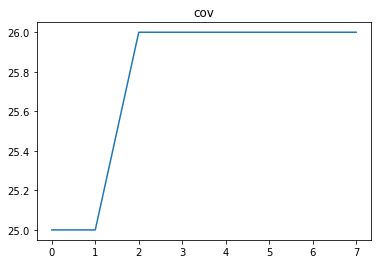

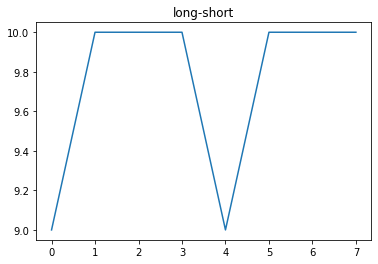

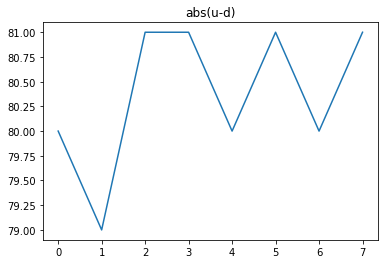

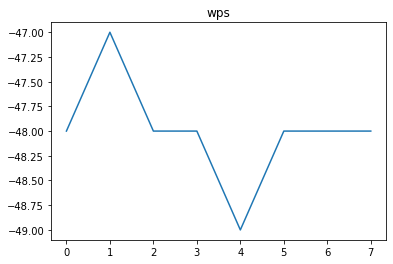

In [20]:
feature_matrix = np.array(feature_matrix_0)
print(feature_matrix.shape)
# print(feature_matrix.shape)
fff1 = np.zeros((8,4),dtype=int)
for i in range(8):
    for j in range(4):
        fff1[i][j] = np.mean([feature_matrix[k][i][j] for k in range(369)])
plt.plot([x for x in range(8)],fff1[:,0])
plt.title('cov')
plt.show()
plt.plot([x for x in range(8)],fff1[:,1])
plt.title('long-short')
plt.show()
plt.plot([x for x in range(8)],fff1[:,2])
plt.title('abs(u-d)')
plt.show()
plt.plot([x for x in range(8)],fff1[:,3])
plt.title('wps')
plt.show()

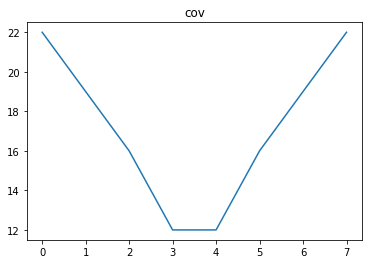

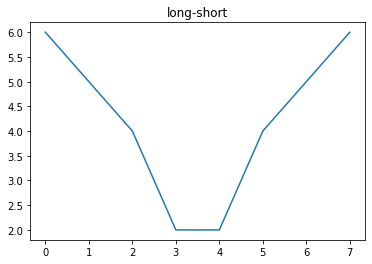

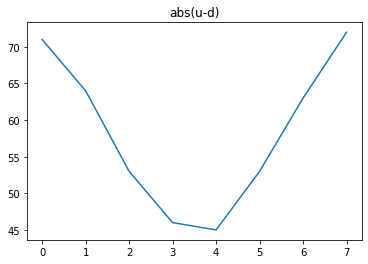

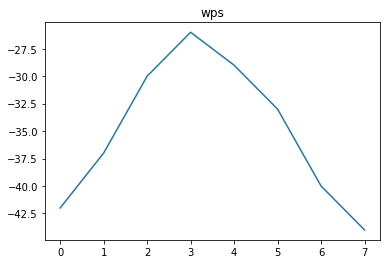

In [21]:
feature_matrix = np.array(feature_matrix_1)
# print(feature_matrix.shape)
fff1 = np.zeros((8,4),dtype=int)
for i in range(8):
    for j in range(4):
        fff1[i][j] = np.mean([feature_matrix[k][i][j] for k in range(369)])
plt.plot([x for x in range(8)],fff1[:,0])
plt.title('cov')
plt.show()
plt.plot([x for x in range(8)],fff1[:,1])
plt.title('long-short')
plt.show()
plt.plot([x for x in range(8)],fff1[:,2])
plt.title('abs(u-d)')
plt.show()
plt.plot([x for x in range(8)],fff1[:,3])
plt.title('wps')
plt.show()

In [71]:
feature_matrix_0 = np.array(feature_matrix_0)
feature_matrix_1 = np.array(feature_matrix_1)
print(feature_matrix_0.shape, feature_matrix_1.shape)

NameError: name 'feature_matrix_1' is not defined